In [1]:
import pandas as pd
import os
import quandl
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize

In [2]:
# config file
parent_path = os.path.abspath(os.path.pardir)
cfg = os.path.join(parent_path,'cfg','quandl_api_key')

In [3]:
# quandl config

with open(cfg, 'r') as file:
    api_key = file.readlines()[0]
    
quandl.ApiConfig.api_key = api_key

In [4]:
# get list of stocks from metadata
metadata_file = 'NSE_metadata.csv'   
metadata_path = os.path.join(parent_path, 'dat', metadata_file)
stocks = pd.read_csv(metadata_path, parse_dates=True)
stocks = stocks.loc[stocks['from_date'] > '2017-01-01', 'code']

total_stocks = stocks.count()

In [5]:
# populate dataframe
data = pd.DataFrame()

for stock in range(total_stocks-1):
    
    raw_data = pd.DataFrame()
    stock_code = stocks.iloc[stock]
    
    raw_data[['price']] = quandl.get( \
                                 'NSE/{}'.format(stock_code), \
                                 column_index=[5], \
                                 start_date='2018-01-01', \
                                 end_date='2018-12-31')
    
    raw_data['ticker'] = stock_code
    
    data = pd.concat([data, raw_data])

In [6]:
# pivot tabular data to cross-section
cross_section = data.pivot(columns='ticker',values='price')

print(cross_section.describe())

ticker  21STCENMGM     3PLAND      5PAISA     63MOONS       AAVAS   ABCAPITAL  \
count   232.000000  130.00000  246.000000  246.000000   57.000000  246.000000   
mean     33.953233   13.00500  308.198374   86.841667  740.783333  138.433333   
std       6.398385    0.99321   77.021682   13.568679   68.197717   24.713529   
min      22.000000   11.05000  177.400000   62.800000  635.100000   94.450000   
25%      27.662500   12.05000  236.500000   76.650000  670.300000  116.250000   
50%      35.750000   13.25000  330.675000   83.575000  767.700000  141.400000   
75%      38.550000   13.85000  358.750000   96.925000  785.900000  156.862500   
max      45.550000   14.95000  486.850000  119.600000  857.500000  186.400000   

ticker   ABMINTLTD    ADANIGAS  ADANIGREEN  ADROITINFO     ...      \
count   159.000000   38.000000  132.000000  171.000000     ...       
mean     30.402516   94.125000   44.182955   26.011111     ...       
std      14.648031   10.606243   10.900887    4.809851     .

In [7]:
print(cross_section.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 246 entries, 2018-01-01 to 2018-12-31
Columns: 188 entries, 21STCENMGM to VIDHIING
dtypes: float64(188)
memory usage: 363.2 KB
None


In [8]:
# pick columns with atleast 240 values 
cross_section = cross_section.loc[ :, cross_section.count().ge(240) ]
print(cross_section.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 246 entries, 2018-01-01 to 2018-12-31
Data columns (total 92 columns):
5PAISA        246 non-null float64
63MOONS       246 non-null float64
ABCAPITAL     246 non-null float64
AGLSL         246 non-null float64
AKSHARCHEM    246 non-null float64
APCL          246 non-null float64
APEX          246 non-null float64
ARIHANTSUP    246 non-null float64
ASTRON        246 non-null float64
AUBANK        246 non-null float64
AVADHSUGAR    246 non-null float64
BHAGYANGR     246 non-null float64
BHAGYAPROP    246 non-null float64
BHANDARI      246 non-null float64
BIOFILCHEM    244 non-null float64
BKMINDST      246 non-null float64
BRNL          246 non-null float64
BSE           246 non-null float64
CAPACITE      246 non-null float64
CAPTRUST      246 non-null float64
CDSL          246 non-null float64
CGPOWER       246 non-null float64
CLEDUCATE     246 non-null float64
COCHINSHIP    246 non-null float64
CORALFINAC    246 non-null float64
D

In [9]:
# calculate returns and standardize prices
df_returns = cross_section.pct_change()
df_prices = 100 * (1 + df_returns).cumprod()

In [10]:
volatility = df_returns.std(axis=0)
mu = df_returns.mean(axis=0)

In [11]:
volatility.describe(percentiles=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])

count    92.000000
mean      0.028509
std       0.008655
min       0.012216
10%       0.017671
20%       0.020828
30%       0.023086
40%       0.025899
50%       0.028676
60%       0.030465
70%       0.032927
80%       0.035676
90%       0.038375
100%      0.059776
max       0.059776
dtype: float64

In [12]:
mu.describe(percentiles=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])

count    92.000000
mean     -0.001925
std       0.001836
min      -0.006712
10%      -0.004065
20%      -0.003386
30%      -0.002751
40%      -0.002363
50%      -0.001765
60%      -0.001399
70%      -0.000921
80%      -0.000390
90%       0.000136
100%      0.001881
max       0.001881
dtype: float64

In [13]:
# parameters for weight estimation
sigma = df_returns.cov()
sigma_inv = np.linalg.inv(sigma)
ones = np.ones((df_returns.shape[1],1))

Sum of weights: 1.0
Sum of weights (post setting negative = 0): 1.0000000000000002


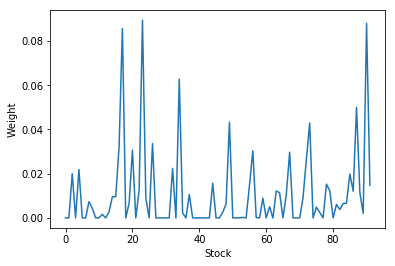

In [14]:
# analytical solution
mv_weight = np.dot(sigma_inv, ones) / np.dot(ones.T, np.dot(sigma_inv,ones))
print('Sum of weights: {}'.format(mv_weight.sum()))

mv_weight[mv_weight < 0] = 0
mv_weight = mv_weight / np.sum(mv_weight)
print('Sum of weights (post setting negative = 0): {}'.format(mv_weight.sum()))

plt.plot(mv_weight)
plt.xlabel('Stock')
plt.ylabel('Weight')
plt.show()

In [15]:
# Minimum volatility - numerical solution - inputs

w = np.random.rand(ones.shape[0])
cons = {'type':'eq','fun':lambda x : np.sum(x) - 1.0 }
bound = ((0.0,1.0))
bounds = (bound,) * w.shape[0]

In [16]:
# objective function
def minimize_volatility(w, sigma = sigma):
    return np.dot(w.T, np.dot(sigma,w))

In [17]:
# minimize
optimizer_output = minimize(minimize_volatility, w, method='SLSQP', bounds=bounds, constraints=cons )

In [18]:
# verification
optimizer_output.x.sum()

1.0000000000000373

In [19]:
# checking positive weights
weights = optimizer_output.x
weights = pd.Series(weights)

# count of positive weights
print('Count of Positive weights: {}'.format(weights.ge(0).sum()))

# shape of w
print('Shape of w vector: {}'.format(w.shape[0]))

Count of Positive weights: 92
Shape of w vector: 92


Sum of weights: 1.0000000000000373
Sum of weights (post setting negative = 0): 1.0


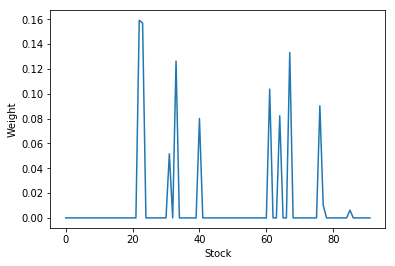

In [20]:
# numerical solution
optimizer_weights = optimizer_output.x
print('Sum of weights: {}'.format(optimizer_weights.sum()))

optimizer_weights[optimizer_weights < 0] = 0
optimizer_weights = optimizer_weights / np.sum(optimizer_weights)
print('Sum of weights (post setting negative = 0): {}'.format(optimizer_weights.sum()))

plt.plot(optimizer_weights)
plt.xlabel('Stock')
plt.ylabel('Weight')
plt.show()